# Analiza zbioru danych Nursery z użyciem sieci SOM

Ten notebook zawiera analizę zbioru danych Nursery oraz wizualizację jego struktury za pomocą sieci SOM.


### Cel datasetu i jego pochodzenie.
Zbiór danych Nursery (Opieka nad Dzieckiem) jest unikatowy, ponieważ nie pochodzi z pomiarów fizycznych ani naturalnych obserwacji, lecz został stworzony jako system ekspercki do klasyfikacji wniosków o przyjęcie dziecka do przedszkola (żłobka) w oparciu o ustalone reguły społeczne i administracyjne.

Korzystano z niego w latach 80. dwudziestego wieku do rozpatrywania aplikacji w szkołach w Ljubljanie. Jego celem było przyśpieszenie procesu rozpatrywania tych aplikacji. Ostateczna decyzja zależała od pod-problemów takich jak status finansowy rodziców, sytuacja społeczna i zdrowotna rodziny etc. Jego autorami są M. Bohanec i V. Rajkovic.

#### Na jakie pytanie chcemy odpowiedzieć?
**Bazując na atrybutach cech przypisanych danej aplikacji, którą klase priorytetu przyjęcia dostanie?**

### Cechy datasetu

Dataset posiada 9 cech: parents, has_nurs, form, children, housing, finance, social, health i class. Cechy te posiadają 2 do 5 atrybutów, poniżej jest ich lista.

- parents: usual, pretentious, great_pret
- has_nurs: proper, less_proper, improper, critical, very_crit
- form: complete, completed, incomplete, foster
- children: 1, 2, 3, more
- housing: convienient, less_conv, critical
- finance: convienient, inconv
- social: non-prob, slightly_prob, problematic
- health: recommended, priority, not_recom
- class: recommended, priority, not_recom

Zmienna przewidywana zawiera atrybuty: not_recom, priority, recommend, spec_prior, very_recom. Wszystkie są kategoryczne, porządkowe oraz dyskretne.

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import Line2D
from sklearn.preprocessing import MinMaxScaler
import random
import time
import pandas as pd
from ucimlrepo import fetch_ucirepo

colnames = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'class']

nursery_data = fetch_ucirepo(id=76)
X_df = nursery_data.data.features
y_df = nursery_data.data.targets
df = pd.concat([X_df, y_df], axis=1)

df.head()

,parents,has_nurs,form,children,housing,finance,social,health,class
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In [10]:
maps = {
    'parents':  {'great_pret': 0, 'pretentious': 1, 'usual': 2},
    'has_nurs': {'very_crit': 0, 'critical': 1, 'improper': 2, 'less_proper': 3, 'proper': 4},
    'form':     {'foster': 0, 'incomplete': 1, 'completed': 2, 'complete': 3},
    'children': {'1': 0, '2': 1, '3': 2, 'more': 3},
    'housing':  {'critical': 0, 'less_conv': 1, 'convenient': 2},
    'finance':  {'inconv': 0, 'convenient': 1},
    'social':   {'problematic': 0, 'slightly_prob': 1, 'nonprob': 2},
    'health':   {'not_recom': 0, 'priority': 1, 'recommended': 2},
    'class':    {'not_recom': 0, 'recommend': 2, 'priority': 1, 'spec_prior': 3, 'very_recom': 4}
}

df_ord = df.replace(maps)

X = df_ord.drop('class', axis=1).values
y = df_ord['class'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


C:\Users\48888\AppData\Local\Temp\ipykernel_22060\3555472273.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ord = df.replace(maps)


### Rozkłady atrybutów

Poniżej pokazane są wykresy rozkładów cech w każdym atrybucie. Można zauważyć, że wszystkie są stałe, poza zmienną przewidywaną, w której jest wyraźny brak atrybutu "recommend".

class
not_recom     4320
priority      4266
recommend        2
spec_prior    4044
very_recom     328
Name: count, dtype: int64


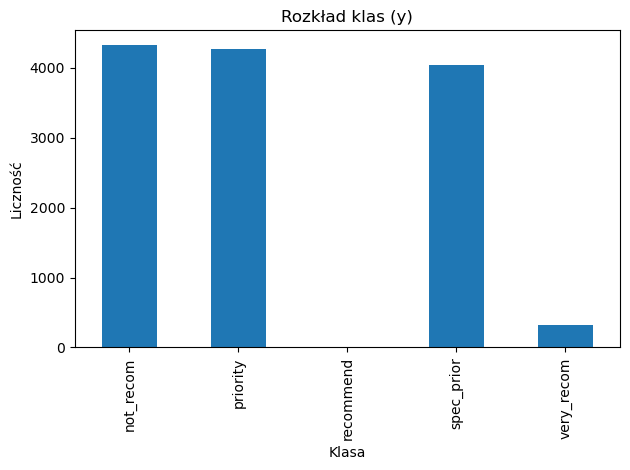

In [11]:
class_counts = df['class'].value_counts().sort_index()
print(class_counts)
ax = class_counts.plot(kind='bar', title='Rozkład klas (y)')
ax.set_xlabel('Klasa')
ax.set_ylabel('Liczność')
plt.tight_layout()
plt.show()

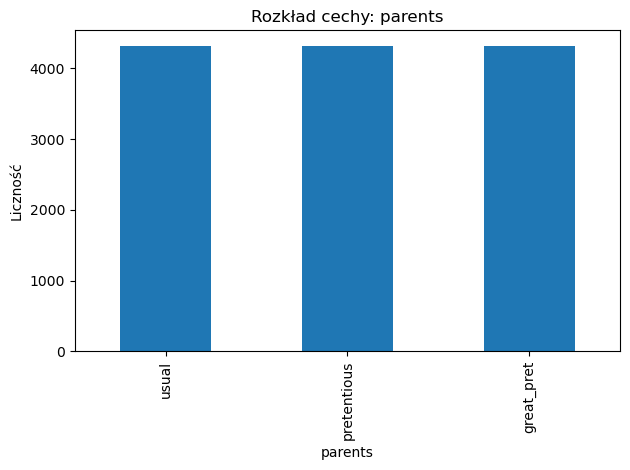

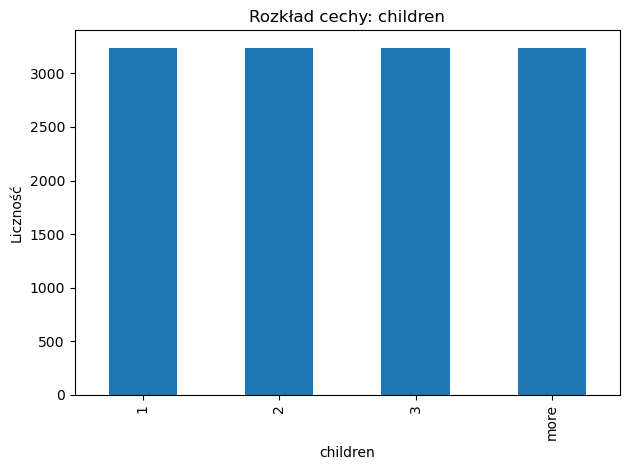

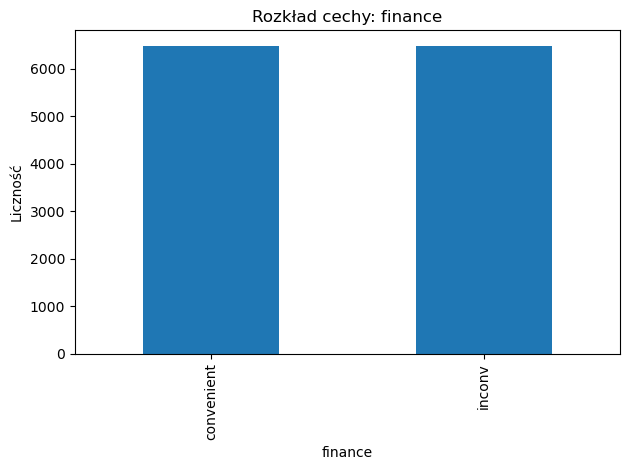

In [12]:
for col in ['parents','children','finance']:
    counts = df[col].value_counts()
    ax = counts.plot(kind='bar', title=f'Rozkład cechy: {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Liczność')
    plt.tight_layout()
    plt.show()

class,not_recom,priority,recommend,spec_prior,very_recom
parents,,,,,
great_pret,1440,858,0,2022,0
pretentious,1440,1484,0,1264,132
usual,1440,1924,2,758,196


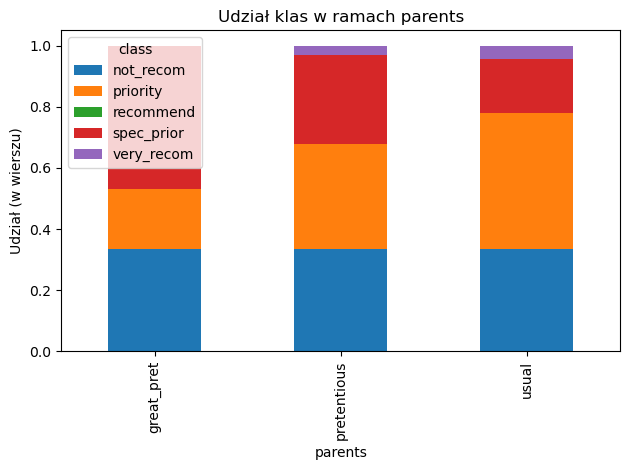

class,not_recom,priority,recommend,spec_prior,very_recom
children,,,,,
1,1080,1206,2,804,148
2,1080,1092,0,968,100
3,1080,984,0,1136,40
more,1080,984,0,1136,40


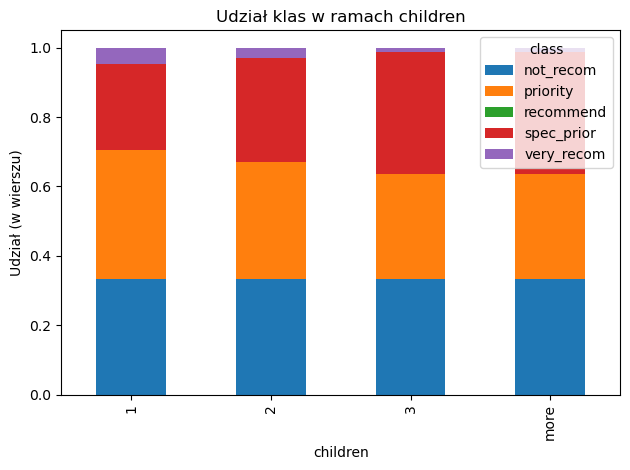

class,not_recom,priority,recommend,spec_prior,very_recom
finance,,,,,
convenient,2160,2244,2,1856,218
inconv,2160,2022,0,2188,110


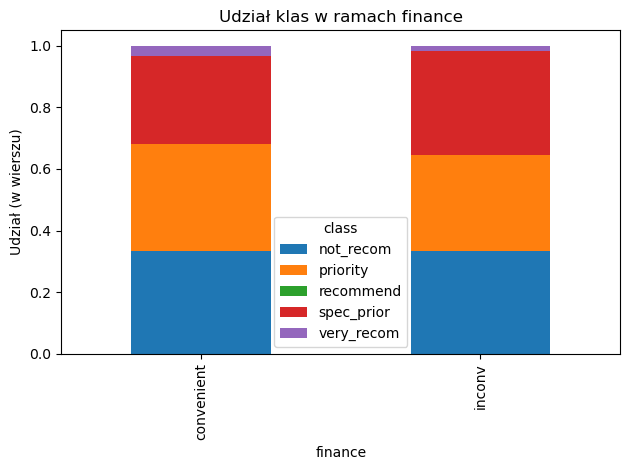

In [13]:
for col in ['parents','children','finance']:
    ct = pd.crosstab(df[col], df['class'])
    display(ct)
    ax = (ct / ct.sum(axis=1).values.reshape(-1,1)).plot(kind='bar', stacked=True, title=f'Udział klas w ramach {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Udział (w wierszu)')
    plt.tight_layout()
    plt.show()

### MiniSOM
Za pomocą biblioteki minisom tworzymy instancje sieci SOM, do której dajemy nasz dataset. Rozmiar jej będzie kierowany wzorem ilości neuronów M = 5 * sqrt(N), gdzie N to ilość próbek N = 12960.

Wymiar sieci SOM (niezaokrąglony): 23.86 x 23.86
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.6227827377055397
Błąd kwantyzacji (QE): 0.622783
Błąd topograficzny (TE): 0.626080


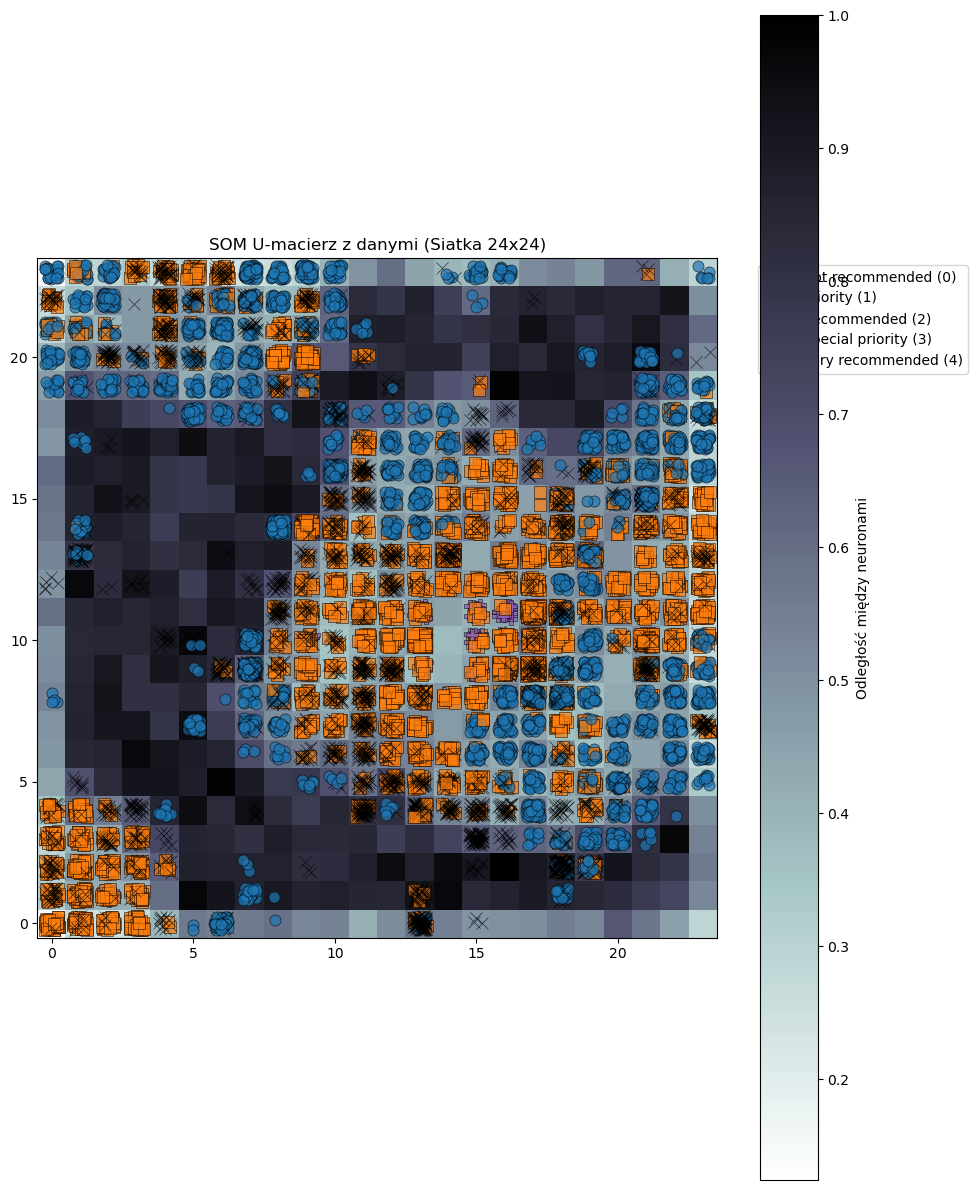

In [17]:
from minisom import MiniSom

M = (5 * (12960) ** 0.5) ** 0.5 

print(f"Wymiar sieci SOM (niezaokrąglony): {M:.2f} x {M:.2f}")

SOM_X_AXIS_NODES  = int(round(M))
SOM_Y_AXIS_NODES  = int(round(M))
SOM_N_VARIABLES  = X_scaled.shape[1]
jitter = lambda: (np.random.rand() - 0.5) * 0.5

MARKERS = ['o', 's', 'D', 'x', 'P']
COLORS = ['C0', 'C1', 'C2', 'C3', 'C4']
CLASS_LABELS = ['Not recommended (0)', 'Priority (1)', 'Recommended (2)', 'Special priority (3)', 'Very recommended (4)']

som = MiniSom(SOM_X_AXIS_NODES, SOM_Y_AXIS_NODES, SOM_N_VARIABLES)

N_ITERATIONS = 5000
som.train_random(X_scaled, N_ITERATIONS, verbose=True)  

quantization_error = som.quantization_error(X_scaled)
topographic_error = som.topographic_error(X_scaled)

print(f"Błąd kwantyzacji (QE): {quantization_error:.6f}")
print(f"Błąd topograficzny (TE): {topographic_error:.6f}")

plt.figure(figsize=(10, 12))

plt.imshow(som.distance_map().T, cmap='bone_r', origin='lower') # U-matrix
plt.colorbar(label='Odległość między neuronami')

for cnt, xx in enumerate(X_scaled):
    w = som.winner(xx) 
    
    plt.plot(w[0] + jitter(), w[1] + jitter(), 
             marker=MARKERS[y[cnt]], 
             color=COLORS[y[cnt]], 
             markersize=8, 
             markeredgecolor='black',
             markeredgewidth=0.5,
             alpha=0.7)
    
legend_elements = [Line2D([0], [0], marker=m, color='w', label=l,
                          markerfacecolor=c, markeredgecolor='k', markersize=10) 
                   for m, c, l in zip(MARKERS, COLORS, CLASS_LABELS)]

plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title(f"SOM U-macierz z danymi (Siatka {SOM_X_AXIS_NODES}x{SOM_Y_AXIS_NODES})")
plt.tight_layout()
plt.show()